# Synchronous Multi-Agent Models

Here, I'll put together a multi-agent environment that has synchronous actions to bridge the gap to our AlphaDow implementation.

## Environment

To make it more similar to AlphaDow, we'll devise a simple, two-stage scheduling problem. Both stages: Stage 0 and Stage 1 are represented by separate agents. Stage 0 produces long campaigns while Stage 1 packs the products in smaller, shorter time steps. Each Stage 0 action takes two time steps while each Stage 1 action takes 1 time step. If Stage 1 chooses to pack an item that is not yet in inventory, nothing happens. Actions for each stage are simply whether or not to produce a product.

There are two products available for Stage 0 and Stage 1 can pack each into one of two different types. For every time, an order is received for a finished product which must be satisfied to receive a reward. Each fulfilled order yields a reward of +10, but is lost if it can't be fulfilled. Additionally, inventory costs of -1 are incurred for every unit of inventory the system is holding.

Observations are the total demand and inventory for each product (**look into allowing individual orders to comprise the state too**). Each agent receives the same observation.

Episodes last for 30 time steps.

In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.rllib.env.multi_agent_env import MultiAgentEnv
import pandas as pd

In [2]:
class MultiStageSchedSyncEnv(MultiAgentEnv):
    '''
    Actions and rewards are taken synchronously. For stage 0, odd timesteps
    don't provide any update.
    '''
    def __init__(self, *args, **kwargs):
        self.num_stages = 2
        self.num_agents = 2
        self.n_zemis = 2
        self.n_zfins = 4
        self.zemis = np.arange(self.n_zemis)
        self.zfins = np.arange(self.n_zfins)
        self.zemi_qty = 2
        self.zfin_qty = 1
        
        self.zfin_zemi_map = {3: 1,
                              2: 1,
                              1: 0,
                              0: 0}
        
        self.max_steps = 30
        self.obs_dim = 2 * (self.n_zemis + self.n_zfins) + 1
        self.observation_space = spaces.Box(
            low=0, high=self.max_steps, 
            shape=(self.obs_dim,))
        self.action_space0 = spaces.Discrete(self.n_zemis)
        self.action_space1 = spaces.Discrete(self.n_zfins)
        self.action_space = spaces.Dict({
            0: self.action_space0,
            1: self.action_space1
        })
        
        self.reset()
        
    def map_zfin_to_zemi(self, zfin):
        return self.zfin_zemi_map[zfin]
    
    def reset(self):
        self.ts = 0
        self.planned_production = {i: np.zeros((self.max_steps, j))
            for i, j in zip(range(self.num_agents), [self.n_zemis, self.n_zfins])}
        self.zemi_inv = np.zeros((self.max_steps, self.n_zemis))
        self.zemi_inv[0] += 1
        self.zfin_inv = np.zeros((self.max_steps, self.n_zfins))
        self.zfin_inv[0] += 1
        self.inventory = np.zeros((self.max_steps, self.n_zemis + self.n_zfins))
        self.demand = np.random.choice(np.arange(self.n_zfins), size=self.max_steps)
        self.state = self._update_state()
        return self.state
    
    def _update_state(self):
        if self.ts > 0:
            self.zemi_inv[self.ts] += self.zemi_inv[self.ts-1]
            self.zfin_inv[self.ts] += self.zfin_inv[self.ts-1]
        self.inventory[self.ts] += np.hstack(
            [self.zemi_inv[self.ts], self.zfin_inv[self.ts]])
        prod_vec = np.hstack([v[self.ts-1] for v in self.planned_production.values()])
        return {i: np.hstack([prod_vec, self.demand[self.ts], self.inventory[self.ts]]) for 
               i in range(self.num_agents)}
        
    
    def step(self, action_dict):
        r = 0
        done = False
        d = self.demand[self.ts] # One unit of demand
        # Begin production to be completed at the next time step.
        for i in range(self.num_agents):
            if i == 0 and self.ts % 2 != 0:
                self.planned_production[i][self.ts] += self.planned_production[i][self.ts-1]
                continue
                
            action = action_dict[i]
            # Add finished products to inventory
            if i == 0 and self.ts > 0:
                self.zemi_inv[self.ts] += self.planned_production[i][self.ts-1]
            elif i > 0 and self.ts > 0:
                self.zfin_inv[self.ts] += self.planned_production[i][self.ts-1]
            
            # Log actions
            if i == 0:
                self.planned_production[i][self.ts][action] += self.zemi_qty
            else:
                # Check raw materials first
                zemi = self.map_zfin_to_zemi(action)
                if self.zemi_inv[self.ts, zemi] >= self.zfin_qty:
                    self.planned_production[i][self.ts][action] += self.zfin_qty
                    self.zemi_inv[self.ts, zemi] -= self.zfin_qty
                               
        # Fulfill demand
        if self.zfin_inv[self.ts, d] > 0:
            self.zfin_inv[self.ts, d] -= 1
            r += 10
            
        # Calculate inventory costs
        r -= self.zfin_inv[self.ts].sum() + self.zemi_inv[self.ts].sum()
        
        self.ts += 1
        self.state = self._update_state()
        
        if self.ts >= self.max_steps-1:
            done = True
        
        rewards = {i: r for i in range(self.num_agents)}
        dones = {i: done for i in range(self.num_agents)}
        dones['__all__'] = done
        info = {i: {} for i in range(self.num_agents)}
        
        return self.state, rewards, dones, info
        
    
env = MultiStageSchedSyncEnv()

In [3]:
# Test env
env.reset()
while True:
#     print(env.ts)
    actions = env.action_space.sample()
    s, r, d, _ = env.step(actions)
    if d['__all__']:
        break

In [5]:
s, r, d, _

({0: array([2., 0., 0., 0., 0., 0., 1., 0., 5., 1., 1., 2., 3.]),
  1: array([2., 0., 0., 0., 0., 0., 1., 0., 5., 1., 1., 2., 3.])},
 {0: -2.0, 1: -2.0},
 {0: True, 1: True, '__all__': True},
 {0: {}, 1: {}})

In [4]:
def env_creator(*args, **kwargs):
    return MultiStageSchedSyncEnv()
env_name = "SyncSched"
tune.register_env(env_name, env_creator)

In [5]:
env = env_creator()

def policy_gen(agent_id):
    if agent_id == 0:
        return (None, env.observation_space, env.action_space0, {})
    elif agent_id == 1:
        return (None, env.observation_space, env.action_space1, {})

policy_graphs = {f'agent-{i}': policy_gen(i) for i in range(env.num_agents)}

def policy_mapping_fn(agent_id):
    return f'agent-{agent_id}'

In [6]:
config={
    "log_level": "WARN",
    "num_workers": 3,
    "num_cpus_for_driver": 1,
    "num_cpus_per_worker": 1,
    "lr": 5e-3,
    "model":{"fcnet_hiddens": [128, 128]},
    "multiagent": {
        "policies": policy_graphs,
        "policy_mapping_fn": policy_mapping_fn,
    },
    "env": env_name
}

exp_name = 'MultiStageSchedSync'

exp_dict = {
        'name': exp_name,
        'run_or_experiment': 'PPO',
        "stop": {
            "training_iteration": 100
        },
        'checkpoint_freq': 20,
        "config": config,
}
ray.init(ignore_reinit_error=True)
results = tune.run(**exp_dict)

2020-12-14 15:49:24,767	INFO resource_spec.py:212 -- Starting Ray with 32.37 GiB memory available for workers and up to 16.19 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-12-14 15:49:25,027	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-12-14 15:49:25,278	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_SyncSched_f11d9_00000,RUNNING,


(pid=2283) 2020-12-14 15:49:27,991	INFO trainer.py:585 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=2283) 2020-12-14 15:49:27,991	INFO trainer.py:612 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=2283) 2020-12-14 15:49:34,132	WARNING util.py:37 -- Install gputil for GPU system monitoring.
Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-49-41
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 120.0
  episode_reward_mean: -103.38888888888889
  episode_reward_min: -384.0
  episodes_this_iter: 144
  episodes_total: 144
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 0.004999999888241291
        entropy: 0.6468084454536438
        entropy_coeff: 0.0
        kl: 0.050289809703826904
        model: {}

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,1,7.48039,4200,-103.389


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-49-47
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 146.0
  episode_reward_mean: -77.5
  episode_reward_min: -384.0
  episodes_this_iter: 144
  episodes_total: 288
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 0.004999999888241291
        entropy: 0.5870267152786255
        entropy_coeff: 0.0
        kl: 0.06724965572357178
        model: {}
        policy_loss: -0.1476057767868042
        total_loss: 1697.93408203125
        vf_explained_var: 1.5087425708770752e-07
        vf_loss: 1698.0615234375
      agent-1:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 0.004999999888241291
        entropy: 1.2660149335861206
        entropy_coeff: 0.0
        kl: 0.06826834380626678
        model: {}
        policy_loss: -0.177049458026886
        total_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,2,13.5766,8400,-77.5


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-49-53
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 146.0
  episode_reward_mean: -60.55555555555556
  episode_reward_min: -274.0
  episodes_this_iter: 144
  episodes_total: 432
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 0.44999998807907104
        cur_lr: 0.004999999888241291
        entropy: 0.5488165020942688
        entropy_coeff: 0.0
        kl: 0.06546467542648315
        model: {}
        policy_loss: -0.14890405535697937
        total_loss: 1142.114013671875
        vf_explained_var: 0.11276251077651978
        vf_loss: 1142.2335205078125
      agent-1:
        cur_kl_coeff: 0.44999998807907104
        cur_lr: 0.004999999888241291
        entropy: 1.2130303382873535
        entropy_coeff: 0.0
        kl: 0.06614577770233154
        model: {}
        policy_loss: -0.193701550364494

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,3,19.7426,12600,-60.5556


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-00
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 138.0
  episode_reward_mean: -67.5374149659864
  episode_reward_min: -324.0
  episodes_this_iter: 147
  episodes_total: 579
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 0.675000011920929
        cur_lr: 0.004999999888241291
        entropy: 0.5353095531463623
        entropy_coeff: 0.0
        kl: 0.04791826754808426
        model: {}
        policy_loss: -0.140385240316391
        total_loss: 896.4613037109375
        vf_explained_var: 0.22712361812591553
        vf_loss: 896.5693359375
      agent-1:
        cur_kl_coeff: 0.675000011920929
        cur_lr: 0.004999999888241291
        entropy: 1.1896581649780273
        entropy_coeff: 0.0
        kl: 0.051693327724933624
        model: {}
        policy_loss: -0.18439309298992157
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,4,25.8187,16800,-67.5374


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-06
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 144.0
  episode_reward_mean: -45.486111111111114
  episode_reward_min: -282.0
  episodes_this_iter: 144
  episodes_total: 723
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 0.5319505929946899
        entropy_coeff: 0.0
        kl: 0.037711530923843384
        model: {}
        policy_loss: -0.12071430683135986
        total_loss: 732.2716064453125
        vf_explained_var: 0.30993056297302246
        vf_loss: 732.3541870117188
      agent-1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1531298160552979
        entropy_coeff: 0.0
        kl: 0.04135729372501373
        model: {}
        policy_loss: -0.1678601205348968

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,5,31.8519,21000,-45.4861


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-12
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 138.0
  episode_reward_mean: -43.291666666666664
  episode_reward_min: -260.0
  episodes_this_iter: 144
  episodes_total: 867
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 0.5384894013404846
        entropy_coeff: 0.0
        kl: 0.028982579708099365
        model: {}
        policy_loss: -0.11979325860738754
        total_loss: 665.7239990234375
        vf_explained_var: 0.33249449729919434
        vf_loss: 665.7998046875
      agent-1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.1344114542007446
        entropy_coeff: 0.0
        kl: 0.03247467428445816
        model: {}
        policy_loss: -0.16352644562721252
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,6,37.9456,25200,-43.2917


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-18
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 178.0
  episode_reward_mean: -35.5
  episode_reward_min: -386.0
  episodes_this_iter: 144
  episodes_total: 1011
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5427248477935791
        entropy_coeff: 0.0
        kl: 0.019328322261571884
        model: {}
        policy_loss: -0.10370069742202759
        total_loss: 900.68994140625
        vf_explained_var: 0.32090306282043457
        vf_loss: 900.7495727539062
      agent-1:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 1.1343854665756226
        entropy_coeff: 0.0
        kl: 0.023944523185491562
        model: {}
        policy_loss: -0.15151676535606384
        total_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,7,43.9657,29400,-35.5


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-24
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 164.0
  episode_reward_mean: -35.034013605442176
  episode_reward_min: -330.0
  episodes_this_iter: 147
  episodes_total: 1158
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5493513345718384
        entropy_coeff: 0.0
        kl: 0.017868708819150925
        model: {}
        policy_loss: -0.10665792226791382
        total_loss: 774.7830810546875
        vf_explained_var: 0.3720773160457611
        vf_loss: 774.84912109375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.1330616474151611
        entropy_coeff: 0.0
        kl: 0.0163329616189003
        model: {}
        policy_loss: -0.12783633172512054
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,8,50.0309,33600,-35.034


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-30
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 180.0
  episode_reward_mean: -40.611111111111114
  episode_reward_min: -422.0
  episodes_this_iter: 144
  episodes_total: 1302
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5515351295471191
        entropy_coeff: 0.0
        kl: 0.018439875915646553
        model: {}
        policy_loss: -0.10486474633216858
        total_loss: 965.5531005859375
        vf_explained_var: 0.3696783185005188
        vf_loss: 965.615966796875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.133829951286316
        entropy_coeff: 0.0
        kl: 0.01671167090535164
        model: {}
        policy_loss: -0.13209012150764465
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,9,56.1145,37800,-40.6111


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-36
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 206.0
  episode_reward_mean: -32.083333333333336
  episode_reward_min: -298.0
  episodes_this_iter: 144
  episodes_total: 1446
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5489659309387207
        entropy_coeff: 0.0
        kl: 0.01821638084948063
        model: {}
        policy_loss: -0.10797180235385895
        total_loss: 860.3479614257812
        vf_explained_var: 0.3666471540927887
        vf_loss: 860.4144287109375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.1241573095321655
        entropy_coeff: 0.0
        kl: 0.016270939260721207
        model: {}
        policy_loss: -0.1371474266052246
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,10,62.1651,42000,-32.0833


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-42
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 244.0
  episode_reward_mean: -25.26530612244898
  episode_reward_min: -312.0
  episodes_this_iter: 147
  episodes_total: 1593
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5487400889396667
        entropy_coeff: 0.0
        kl: 0.017869209870696068
        model: {}
        policy_loss: -0.10476996004581451
        total_loss: 691.6472778320312
        vf_explained_var: 0.39779701828956604
        vf_loss: 691.7113647460938
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.1161695718765259
        entropy_coeff: 0.0
        kl: 0.01721995510160923
        model: {}
        policy_loss: -0.137337327003479
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,11,68.2333,46200,-25.2653


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-49
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 190.0
  episode_reward_mean: -20.76388888888889
  episode_reward_min: -396.0
  episodes_this_iter: 144
  episodes_total: 1737
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5437732338905334
        entropy_coeff: 0.0
        kl: 0.01833447441458702
        model: {}
        policy_loss: -0.1069386899471283
        total_loss: 629.4480590820312
        vf_explained_var: 0.3998923599720001
        vf_loss: 629.51318359375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.1247260570526123
        entropy_coeff: 0.0
        kl: 0.016251958906650543
        model: {}
        policy_loss: -0.1330394446849823
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,12,74.3302,50400,-20.7639


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-50-55
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 212.0
  episode_reward_mean: -14.583333333333334
  episode_reward_min: -266.0
  episodes_this_iter: 144
  episodes_total: 1881
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5483161211013794
        entropy_coeff: 0.0
        kl: 0.019248196855187416
        model: {}
        policy_loss: -0.11214014887809753
        total_loss: 691.7591552734375
        vf_explained_var: 0.40511101484298706
        vf_loss: 691.8275146484375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.109347939491272
        entropy_coeff: 0.0
        kl: 0.016036245971918106
        model: {}
        policy_loss: -0.13429462909698486

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,13,80.4387,54600,-14.5833


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-01
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 238.0
  episode_reward_mean: -12.11111111111111
  episode_reward_min: -246.0
  episodes_this_iter: 144
  episodes_total: 2025
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.543534517288208
        entropy_coeff: 0.0
        kl: 0.018359705805778503
        model: {}
        policy_loss: -0.10861790180206299
        total_loss: 639.6550903320312
        vf_explained_var: 0.38510453701019287
        vf_loss: 639.7218627929688
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.1118366718292236
        entropy_coeff: 0.0
        kl: 0.016947362571954727
        model: {}
        policy_loss: -0.1353953629732132
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,14,86.5034,58800,-12.1111


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-07
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 202.0
  episode_reward_mean: -14.802721088435375
  episode_reward_min: -272.0
  episodes_this_iter: 147
  episodes_total: 2172
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5458962917327881
        entropy_coeff: 0.0
        kl: 0.017683595418930054
        model: {}
        policy_loss: -0.11023260653018951
        total_loss: 739.0779418945312
        vf_explained_var: 0.4284663498401642
        vf_loss: 739.1478271484375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0986173152923584
        entropy_coeff: 0.0
        kl: 0.01630229316651821
        model: {}
        policy_loss: -0.1325262188911438
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,15,92.5248,63000,-14.8027


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-13
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 200.0
  episode_reward_mean: 5.402777777777778
  episode_reward_min: -240.0
  episodes_this_iter: 144
  episodes_total: 2316
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5518624782562256
        entropy_coeff: 0.0
        kl: 0.01931685023009777
        model: {}
        policy_loss: -0.10536570847034454
        total_loss: 573.2001342773438
        vf_explained_var: 0.42706966400146484
        vf_loss: 573.261474609375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0961495637893677
        entropy_coeff: 0.0
        kl: 0.016467243432998657
        model: {}
        policy_loss: -0.1296353042125702
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,16,98.6358,67200,5.40278


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-19
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 222.0
  episode_reward_mean: 6.055555555555555
  episode_reward_min: -290.0
  episodes_this_iter: 144
  episodes_total: 2460
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5513695478439331
        entropy_coeff: 0.0
        kl: 0.01865234039723873
        model: {}
        policy_loss: -0.10654600709676743
        total_loss: 579.2684936523438
        vf_explained_var: 0.410443514585495
        vf_loss: 579.3326416015625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0914280414581299
        entropy_coeff: 0.0
        kl: 0.015937354415655136
        model: {}
        policy_loss: -0.13052476942539215
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,17,104.642,71400,6.05556


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-25
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 210.0
  episode_reward_mean: 10.791666666666666
  episode_reward_min: -290.0
  episodes_this_iter: 144
  episodes_total: 2604
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5489010810852051
        entropy_coeff: 0.0
        kl: 0.01820126175880432
        model: {}
        policy_loss: -0.10862959921360016
        total_loss: 595.3056640625
        vf_explained_var: 0.4347565472126007
        vf_loss: 595.372802734375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.090916395187378
        entropy_coeff: 0.0
        kl: 0.016073070466518402
        model: {}
        policy_loss: -0.12523841857910156
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,18,110.895,75600,10.7917


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-32
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 292.0
  episode_reward_mean: 16.612244897959183
  episode_reward_min: -280.0
  episodes_this_iter: 147
  episodes_total: 2751
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5503052473068237
        entropy_coeff: 0.0
        kl: 0.01765695959329605
        model: {}
        policy_loss: -0.1074676588177681
        total_loss: 589.908447265625
        vf_explained_var: 0.42243269085884094
        vf_loss: 589.9757690429688
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.08402419090271
        entropy_coeff: 0.0
        kl: 0.015783127397298813
        model: {}
        policy_loss: -0.12795330584049225
    

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,19,117.061,79800,16.6122


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-38
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 208.0
  episode_reward_mean: 6.652777777777778
  episode_reward_min: -426.0
  episodes_this_iter: 144
  episodes_total: 2895
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5516566038131714
        entropy_coeff: 0.0
        kl: 0.017792459577322006
        model: {}
        policy_loss: -0.10348436236381531
        total_loss: 634.744873046875
        vf_explained_var: 0.41599005460739136
        vf_loss: 634.8077392578125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0867063999176025
        entropy_coeff: 0.0
        kl: 0.015649747103452682
        model: {}
        policy_loss: -0.13161641359329224
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,20,123.211,84000,6.65278


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-44
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 230.0
  episode_reward_mean: 3.763888888888889
  episode_reward_min: -466.0
  episodes_this_iter: 144
  episodes_total: 3039
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5501554012298584
        entropy_coeff: 0.0
        kl: 0.01792009547352791
        model: {}
        policy_loss: -0.10396568477153778
        total_loss: 730.5654296875
        vf_explained_var: 0.4534037709236145
        vf_loss: 730.6286010742188
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0786783695220947
        entropy_coeff: 0.0
        kl: 0.016147788614034653
        model: {}
        policy_loss: -0.12708114087581635
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,21,129.239,88200,3.76389


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-50
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 262.0
  episode_reward_mean: 19.496598639455783
  episode_reward_min: -312.0
  episodes_this_iter: 147
  episodes_total: 3186
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5497788190841675
        entropy_coeff: 0.0
        kl: 0.017961086705327034
        model: {}
        policy_loss: -0.11031798273324966
        total_loss: 542.4020385742188
        vf_explained_var: 0.4509994685649872
        vf_loss: 542.471435546875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0650129318237305
        entropy_coeff: 0.0
        kl: 0.0158100426197052
        model: {}
        policy_loss: -0.13212761282920837
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,22,135.273,92400,19.4966


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-51-56
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 208.0
  episode_reward_mean: 3.3055555555555554
  episode_reward_min: -262.0
  episodes_this_iter: 144
  episodes_total: 3330
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5471131801605225
        entropy_coeff: 0.0
        kl: 0.018365859985351562
        model: {}
        policy_loss: -0.10958503186702728
        total_loss: 566.6507568359375
        vf_explained_var: 0.44802695512771606
        vf_loss: 566.7184448242188
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0701994895935059
        entropy_coeff: 0.0
        kl: 0.016564493998885155
        model: {}
        policy_loss: -0.13176485896110535

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,23,141.23,96600,3.30556


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-02
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 224.0
  episode_reward_mean: 28.430555555555557
  episode_reward_min: -176.0
  episodes_this_iter: 144
  episodes_total: 3474
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5431183576583862
        entropy_coeff: 0.0
        kl: 0.018462032079696655
        model: {}
        policy_loss: -0.1069534420967102
        total_loss: 443.0136413574219
        vf_explained_var: 0.49509578943252563
        vf_loss: 443.0785217285156
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0683529376983643
        entropy_coeff: 0.0
        kl: 0.016359636560082436
        model: {}
        policy_loss: -0.12790870666503906


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,24,147.21,100800,28.4306


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-08
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 204.0
  episode_reward_mean: 31.52777777777778
  episode_reward_min: -168.0
  episodes_this_iter: 144
  episodes_total: 3618
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5486974716186523
        entropy_coeff: 0.0
        kl: 0.0188867449760437
        model: {}
        policy_loss: -0.10915270447731018
        total_loss: 502.34979248046875
        vf_explained_var: 0.45859479904174805
        vf_loss: 502.4158935546875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0619268417358398
        entropy_coeff: 0.0
        kl: 0.01590314693748951
        model: {}
        policy_loss: -0.13511721789836884
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,25,153.362,105000,31.5278


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-15
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 244.0
  episode_reward_mean: 35.197278911564624
  episode_reward_min: -278.0
  episodes_this_iter: 147
  episodes_total: 3765
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5466225743293762
        entropy_coeff: 0.0
        kl: 0.017359022051095963
        model: {}
        policy_loss: -0.10499466955661774
        total_loss: 530.5297241210938
        vf_explained_var: 0.46756473183631897
        vf_loss: 530.59521484375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.050590991973877
        entropy_coeff: 0.0
        kl: 0.014799922704696655
        model: {}
        policy_loss: -0.1319415122270584
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,26,159.416,109200,35.1973


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-21
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 194.0
  episode_reward_mean: 32.18055555555556
  episode_reward_min: -176.0
  episodes_this_iter: 144
  episodes_total: 3909
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5434567928314209
        entropy_coeff: 0.0
        kl: 0.01837778091430664
        model: {}
        policy_loss: -0.10704624652862549
        total_loss: 400.0548400878906
        vf_explained_var: 0.4780697226524353
        vf_loss: 400.1200256347656
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0453554391860962
        entropy_coeff: 0.0
        kl: 0.015632687136530876
        model: {}
        policy_loss: -0.12889546155929565
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,27,165.453,113400,32.1806


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-27
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 226.0
  episode_reward_mean: 41.166666666666664
  episode_reward_min: -368.0
  episodes_this_iter: 144
  episodes_total: 4053
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5490097403526306
        entropy_coeff: 0.0
        kl: 0.017283357679843903
        model: {}
        policy_loss: -0.09647288173437119
        total_loss: 513.406494140625
        vf_explained_var: 0.4553876519203186
        vf_loss: 513.463623046875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0364078283309937
        entropy_coeff: 0.0
        kl: 0.014637904241681099
        model: {}
        policy_loss: -0.12087169289588928
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,28,171.522,117600,41.1667


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-33
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 224.0
  episode_reward_mean: 29.959183673469386
  episode_reward_min: -246.0
  episodes_this_iter: 147
  episodes_total: 4200
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5537590384483337
        entropy_coeff: 0.0
        kl: 0.018123682588338852
        model: {}
        policy_loss: -0.10532642900943756
        total_loss: 566.8357543945312
        vf_explained_var: 0.44636765122413635
        vf_loss: 566.8998413085938
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0350306034088135
        entropy_coeff: 0.0
        kl: 0.014918394386768341
        model: {}
        policy_loss: -0.1169285923242569


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,29,177.582,121800,29.9592


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-39
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 210.0
  episode_reward_mean: 33.666666666666664
  episode_reward_min: -210.0
  episodes_this_iter: 144
  episodes_total: 4344
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5509975552558899
        entropy_coeff: 0.0
        kl: 0.01812410168349743
        model: {}
        policy_loss: -0.10904952883720398
        total_loss: 477.3050842285156
        vf_explained_var: 0.48293831944465637
        vf_loss: 477.3728332519531
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0461530685424805
        entropy_coeff: 0.0
        kl: 0.015731194987893105
        model: {}
        policy_loss: -0.12275928258895874


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,30,183.635,126000,33.6667


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-45
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 222.0
  episode_reward_mean: 28.458333333333332
  episode_reward_min: -386.0
  episodes_this_iter: 144
  episodes_total: 4488
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5533599257469177
        entropy_coeff: 0.0
        kl: 0.01756133884191513
        model: {}
        policy_loss: -0.10689489543437958
        total_loss: 606.7750244140625
        vf_explained_var: 0.4651739001274109
        vf_loss: 606.8419189453125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0456256866455078
        entropy_coeff: 0.0
        kl: 0.015067987143993378
        model: {}
        policy_loss: -0.11900708079338074
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,31,189.667,130200,28.4583


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-51
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 230.0
  episode_reward_mean: 39.083333333333336
  episode_reward_min: -174.0
  episodes_this_iter: 144
  episodes_total: 4632
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5533646941184998
        entropy_coeff: 0.0
        kl: 0.017053799703717232
        model: {}
        policy_loss: -0.10908438265323639
        total_loss: 513.9638061523438
        vf_explained_var: 0.4636134207248688
        vf_loss: 514.0339965820312
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0402815341949463
        entropy_coeff: 0.0
        kl: 0.015485291369259357
        model: {}
        policy_loss: -0.1258828043937683
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,32,195.632,134400,39.0833


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-52-57
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 218.0
  episode_reward_mean: 39.63265306122449
  episode_reward_min: -304.0
  episodes_this_iter: 147
  episodes_total: 4779
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5481579899787903
        entropy_coeff: 0.0
        kl: 0.01657411828637123
        model: {}
        policy_loss: -0.10735737532377243
        total_loss: 497.5323181152344
        vf_explained_var: 0.4587920904159546
        vf_loss: 497.6019287109375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.022849202156067
        entropy_coeff: 0.0
        kl: 0.014823218807578087
        model: {}
        policy_loss: -0.12517984211444855
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,33,201.663,138600,39.6327


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-03
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 254.0
  episode_reward_mean: 49.583333333333336
  episode_reward_min: -160.0
  episodes_this_iter: 144
  episodes_total: 4923
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5477275848388672
        entropy_coeff: 0.0
        kl: 0.01760678179562092
        model: {}
        policy_loss: -0.10612031817436218
        total_loss: 472.37884521484375
        vf_explained_var: 0.4952234625816345
        vf_loss: 472.44488525390625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0321012735366821
        entropy_coeff: 0.0
        kl: 0.015324808657169342
        model: {}
        policy_loss: -0.12486471980810165

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,34,207.728,142800,49.5833


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-09
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 278.0
  episode_reward_mean: 52.40277777777778
  episode_reward_min: -232.0
  episodes_this_iter: 144
  episodes_total: 5067
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5434399247169495
        entropy_coeff: 0.0
        kl: 0.0179365836083889
        model: {}
        policy_loss: -0.09981068968772888
        total_loss: 529.087646484375
        vf_explained_var: 0.47719594836235046
        vf_loss: 529.1466064453125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.027498722076416
        entropy_coeff: 0.0
        kl: 0.014938805252313614
        model: {}
        policy_loss: -0.12451788783073425
    

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,35,213.877,147000,52.4028


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-16
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 264.0
  episode_reward_mean: 66.58333333333333
  episode_reward_min: -106.0
  episodes_this_iter: 144
  episodes_total: 5211
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5408719778060913
        entropy_coeff: 0.0
        kl: 0.01687869429588318
        model: {}
        policy_loss: -0.10511330515146255
        total_loss: 396.4179382324219
        vf_explained_var: 0.4974491000175476
        vf_loss: 396.48455810546875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0242104530334473
        entropy_coeff: 0.0
        kl: 0.015871137380599976
        model: {}
        policy_loss: -0.12123896181583405
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,36,220.019,151200,66.5833


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-22
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 218.0
  episode_reward_mean: 43.904761904761905
  episode_reward_min: -222.0
  episodes_this_iter: 147
  episodes_total: 5358
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5501120090484619
        entropy_coeff: 0.0
        kl: 0.017359625548124313
        model: {}
        policy_loss: -0.10524541139602661
        total_loss: 522.3272705078125
        vf_explained_var: 0.4705876410007477
        vf_loss: 522.3929443359375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0220463275909424
        entropy_coeff: 0.0
        kl: 0.015073727816343307
        model: {}
        policy_loss: -0.12388245016336441


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,37,226.036,155400,43.9048


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-28
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 224.0
  episode_reward_mean: 47.27777777777778
  episode_reward_min: -218.0
  episodes_this_iter: 144
  episodes_total: 5502
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5482217669487
        entropy_coeff: 0.0
        kl: 0.01764588989317417
        model: {}
        policy_loss: -0.11253185570240021
        total_loss: 527.775146484375
        vf_explained_var: 0.4690457880496979
        vf_loss: 527.8474731445312
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0122240781784058
        entropy_coeff: 0.0
        kl: 0.014815962873399258
        model: {}
        policy_loss: -0.1343284547328949
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,38,232.172,159600,47.2778


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-34
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 238.0
  episode_reward_mean: 47.833333333333336
  episode_reward_min: -162.0
  episodes_this_iter: 144
  episodes_total: 5646
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5436066389083862
        entropy_coeff: 0.0
        kl: 0.01719227246940136
        model: {}
        policy_loss: -0.10757365822792053
        total_loss: 479.8758544921875
        vf_explained_var: 0.45419836044311523
        vf_loss: 479.9442443847656
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0077205896377563
        entropy_coeff: 0.0
        kl: 0.014588305726647377
        model: {}
        policy_loss: -0.12258675694465637


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,39,238.265,163800,47.8333


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-40
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 256.0
  episode_reward_mean: 59.85034013605442
  episode_reward_min: -290.0
  episodes_this_iter: 147
  episodes_total: 5793
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5469669103622437
        entropy_coeff: 0.0
        kl: 0.01760011352598667
        model: {}
        policy_loss: -0.1039639562368393
        total_loss: 536.951171875
        vf_explained_var: 0.45841842889785767
        vf_loss: 537.0150756835938
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0012444257736206
        entropy_coeff: 0.0
        kl: 0.014283034950494766
        model: {}
        policy_loss: -0.11712570488452911
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,40,244.494,168000,59.8503


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-46
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 210.0
  episode_reward_mean: 47.791666666666664
  episode_reward_min: -180.0
  episodes_this_iter: 144
  episodes_total: 5937
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5478082299232483
        entropy_coeff: 0.0
        kl: 0.017467636615037918
        model: {}
        policy_loss: -0.10692015290260315
        total_loss: 379.24041748046875
        vf_explained_var: 0.4850291311740875
        vf_loss: 379.3075256347656
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.013060450553894
        entropy_coeff: 0.0
        kl: 0.01547916978597641
        model: {}
        policy_loss: -0.1210516095161438
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,41,250.551,172200,47.7917


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-53
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 274.0
  episode_reward_mean: 47.34722222222222
  episode_reward_min: -240.0
  episodes_this_iter: 144
  episodes_total: 6081
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5465425848960876
        entropy_coeff: 0.0
        kl: 0.018180478364229202
        model: {}
        policy_loss: -0.11074092239141464
        total_loss: 504.50311279296875
        vf_explained_var: 0.5144107341766357
        vf_loss: 504.5724182128906
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 1.0021851062774658
        entropy_coeff: 0.0
        kl: 0.01541958749294281
        model: {}
        policy_loss: -0.12142180651426315
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,42,256.682,176400,47.3472


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-53-59
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 278.0
  episode_reward_mean: 55.513888888888886
  episode_reward_min: -192.0
  episodes_this_iter: 144
  episodes_total: 6225
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5480654835700989
        entropy_coeff: 0.0
        kl: 0.017793498933315277
        model: {}
        policy_loss: -0.10714778304100037
        total_loss: 528.0802001953125
        vf_explained_var: 0.4673784375190735
        vf_loss: 528.1468505859375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9888142347335815
        entropy_coeff: 0.0
        kl: 0.01570182293653488
        model: {}
        policy_loss: -0.11901502311229706
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,43,262.805,180600,55.5139


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-05
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 270.0
  episode_reward_mean: 58.42176870748299
  episode_reward_min: -238.0
  episodes_this_iter: 147
  episodes_total: 6372
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5393708348274231
        entropy_coeff: 0.0
        kl: 0.017119310796260834
        model: {}
        policy_loss: -0.11161643266677856
        total_loss: 415.206787109375
        vf_explained_var: 0.48902183771133423
        vf_loss: 415.27935791015625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9880492091178894
        entropy_coeff: 0.0
        kl: 0.01460011675953865
        model: {}
        policy_loss: -0.12155017256736755
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,44,269.061,184800,58.4218


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-11
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 226.0
  episode_reward_mean: 57.0
  episode_reward_min: -174.0
  episodes_this_iter: 144
  episodes_total: 6516
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.533581554889679
        entropy_coeff: 0.0
        kl: 0.017656289041042328
        model: {}
        policy_loss: -0.10537972301244736
        total_loss: 451.92608642578125
        vf_explained_var: 0.5049909353256226
        vf_loss: 451.9912109375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.979951798915863
        entropy_coeff: 0.0
        kl: 0.01514396071434021
        model: {}
        policy_loss: -0.1184341311454773
        total_loss: 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,45,275.215,189000,57


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-17
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 244.0
  episode_reward_mean: 64.97222222222223
  episode_reward_min: -260.0
  episodes_this_iter: 144
  episodes_total: 6660
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5318715572357178
        entropy_coeff: 0.0
        kl: 0.01686568558216095
        model: {}
        policy_loss: -0.10382760316133499
        total_loss: 386.20849609375
        vf_explained_var: 0.49178433418273926
        vf_loss: 386.2738952636719
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9755696058273315
        entropy_coeff: 0.0
        kl: 0.013898193836212158
        model: {}
        policy_loss: -0.11378055810928345
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,46,281.256,193200,64.9722


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-24
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 238.0
  episode_reward_mean: 64.43055555555556
  episode_reward_min: -134.0
  episodes_this_iter: 144
  episodes_total: 6804
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5334798097610474
        entropy_coeff: 0.0
        kl: 0.017557958140969276
        model: {}
        policy_loss: -0.10567944496870041
        total_loss: 446.2112121582031
        vf_explained_var: 0.49743562936782837
        vf_loss: 446.2768859863281
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9733554124832153
        entropy_coeff: 0.0
        kl: 0.01496884785592556
        model: {}
        policy_loss: -0.12102700769901276
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,47,287.432,197400,64.4306


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-30
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 270.0
  episode_reward_mean: 69.31972789115646
  episode_reward_min: -198.0
  episodes_this_iter: 147
  episodes_total: 6951
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5336368083953857
        entropy_coeff: 0.0
        kl: 0.016772452741861343
        model: {}
        policy_loss: -0.10744958370923996
        total_loss: 531.0220947265625
        vf_explained_var: 0.4857245683670044
        vf_loss: 531.0913696289062
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9658475518226624
        entropy_coeff: 0.0
        kl: 0.013218679465353489
        model: {}
        policy_loss: -0.11680525541305542
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,48,293.496,201600,69.3197


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-36
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 260.0
  episode_reward_mean: 71.18055555555556
  episode_reward_min: -146.0
  episodes_this_iter: 144
  episodes_total: 7095
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5380346775054932
        entropy_coeff: 0.0
        kl: 0.017636260017752647
        model: {}
        policy_loss: -0.10643287003040314
        total_loss: 474.0546875
        vf_explained_var: 0.48524531722068787
        vf_loss: 474.1209716796875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9563516974449158
        entropy_coeff: 0.0
        kl: 0.014705014415085316
        model: {}
        policy_loss: -0.11776935309171677
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,49,299.588,205800,71.1806


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-42
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 242.0
  episode_reward_mean: 67.73611111111111
  episode_reward_min: -160.0
  episodes_this_iter: 144
  episodes_total: 7239
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5354124307632446
        entropy_coeff: 0.0
        kl: 0.018261956050992012
        model: {}
        policy_loss: -0.10284318029880524
        total_loss: 398.4210205078125
        vf_explained_var: 0.5219817757606506
        vf_loss: 398.48223876953125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9611895680427551
        entropy_coeff: 0.0
        kl: 0.014785385690629482
        model: {}
        policy_loss: -0.1125997006893158
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,50,305.746,210000,67.7361


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-48
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 306.0
  episode_reward_mean: 80.82993197278911
  episode_reward_min: -206.0
  episodes_this_iter: 147
  episodes_total: 7386
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5382843017578125
        entropy_coeff: 0.0
        kl: 0.017011595889925957
        model: {}
        policy_loss: -0.09729644656181335
        total_loss: 449.02618408203125
        vf_explained_var: 0.5165581703186035
        vf_loss: 449.084716796875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9514620304107666
        entropy_coeff: 0.0
        kl: 0.014079161919653416
        model: {}
        policy_loss: -0.10617129504680634
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,51,311.847,214200,80.8299


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-54-55
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 254.0
  episode_reward_mean: 80.04166666666667
  episode_reward_min: -186.0
  episodes_this_iter: 144
  episodes_total: 7530
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5392531752586365
        entropy_coeff: 0.0
        kl: 0.016546305269002914
        model: {}
        policy_loss: -0.1023813933134079
        total_loss: 446.3408203125
        vf_explained_var: 0.5139358639717102
        vf_loss: 446.405517578125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9459123611450195
        entropy_coeff: 0.0
        kl: 0.014323171228170395
        model: {}
        policy_loss: -0.10770444571971893
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,52,317.978,218400,80.0417


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-01
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 284.0
  episode_reward_mean: 65.5
  episode_reward_min: -288.0
  episodes_this_iter: 144
  episodes_total: 7674
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5371577143669128
        entropy_coeff: 0.0
        kl: 0.017270933836698532
        model: {}
        policy_loss: -0.1064981073141098
        total_loss: 520.266845703125
        vf_explained_var: 0.4860098361968994
        vf_loss: 520.333984375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9543925523757935
        entropy_coeff: 0.0
        kl: 0.014914433471858501
        model: {}
        policy_loss: -0.10600513964891434
        total_loss: 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,53,324.062,222600,65.5


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-07
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 250.0
  episode_reward_mean: 79.66666666666667
  episode_reward_min: -148.0
  episodes_this_iter: 144
  episodes_total: 7818
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5375635623931885
        entropy_coeff: 0.0
        kl: 0.01704932190477848
        model: {}
        policy_loss: -0.09506125748157501
        total_loss: 438.5611572265625
        vf_explained_var: 0.488092303276062
        vf_loss: 438.6174011230469
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9420615434646606
        entropy_coeff: 0.0
        kl: 0.013281486928462982
        model: {}
        policy_loss: -0.10571961849927902
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,54,330.154,226800,79.6667


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-13
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 250.0
  episode_reward_mean: 67.79591836734694
  episode_reward_min: -146.0
  episodes_this_iter: 147
  episodes_total: 7965
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5409143567085266
        entropy_coeff: 0.0
        kl: 0.017461270093917847
        model: {}
        policy_loss: -0.10840007662773132
        total_loss: 439.9100341796875
        vf_explained_var: 0.5109729766845703
        vf_loss: 439.9786682128906
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9507889747619629
        entropy_coeff: 0.0
        kl: 0.014272612519562244
        model: {}
        policy_loss: -0.11310084909200668
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,55,336.278,231000,67.7959


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-19
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 256.0
  episode_reward_mean: 78.27777777777777
  episode_reward_min: -224.0
  episodes_this_iter: 144
  episodes_total: 8109
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5399375557899475
        entropy_coeff: 0.0
        kl: 0.017155846580863
        model: {}
        policy_loss: -0.09881934523582458
        total_loss: 499.9189147949219
        vf_explained_var: 0.5245000123977661
        vf_loss: 499.9786376953125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.946096658706665
        entropy_coeff: 0.0
        kl: 0.01364956796169281
        model: {}
        policy_loss: -0.11115962266921997
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,56,342.365,235200,78.2778


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-25
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 244.0
  episode_reward_mean: 81.0
  episode_reward_min: -206.0
  episodes_this_iter: 144
  episodes_total: 8253
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5419869422912598
        entropy_coeff: 0.0
        kl: 0.017395440489053726
        model: {}
        policy_loss: -0.09971235692501068
        total_loss: 451.9736328125
        vf_explained_var: 0.49989181756973267
        vf_loss: 452.03369140625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9301647543907166
        entropy_coeff: 0.0
        kl: 0.013383054174482822
        model: {}
        policy_loss: -0.11127957701683044
        total_loss

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,57,348.462,239400,81


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-31
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 252.0
  episode_reward_mean: 75.56462585034014
  episode_reward_min: -162.0
  episodes_this_iter: 147
  episodes_total: 8400
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5392526388168335
        entropy_coeff: 0.0
        kl: 0.016334600746631622
        model: {}
        policy_loss: -0.10176778584718704
        total_loss: 424.4258117675781
        vf_explained_var: 0.5062123537063599
        vf_loss: 424.4903869628906
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9298846125602722
        entropy_coeff: 0.0
        kl: 0.013888310641050339
        model: {}
        policy_loss: -0.11549623310565948
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,58,354.517,243600,75.5646


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-37
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 272.0
  episode_reward_mean: 84.44444444444444
  episode_reward_min: -174.0
  episodes_this_iter: 144
  episodes_total: 8544
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5396305322647095
        entropy_coeff: 0.0
        kl: 0.016701439395546913
        model: {}
        policy_loss: -0.09880216419696808
        total_loss: 420.31427001953125
        vf_explained_var: 0.5189430713653564
        vf_loss: 420.375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9287450909614563
        entropy_coeff: 0.0
        kl: 0.0138503797352314
        model: {}
        policy_loss: -0.10710902512073517
        tota

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,59,360.531,247800,84.4444


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-44
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 230.0
  episode_reward_mean: 79.27777777777777
  episode_reward_min: -132.0
  episodes_this_iter: 144
  episodes_total: 8688
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5391956567764282
        entropy_coeff: 0.0
        kl: 0.017273420467972755
        model: {}
        policy_loss: -0.1008676066994667
        total_loss: 409.4873962402344
        vf_explained_var: 0.5154226422309875
        vf_loss: 409.54888916015625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9163773655891418
        entropy_coeff: 0.0
        kl: 0.014294564723968506
        model: {}
        policy_loss: -0.10738269239664078
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,60,366.776,252000,79.2778


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-50
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 290.0
  episode_reward_mean: 81.86111111111111
  episode_reward_min: -174.0
  episodes_this_iter: 144
  episodes_total: 8832
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5365537405014038
        entropy_coeff: 0.0
        kl: 0.016629893332719803
        model: {}
        policy_loss: -0.09783629328012466
        total_loss: 407.96240234375
        vf_explained_var: 0.5085563659667969
        vf_loss: 408.0223693847656
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9264683723449707
        entropy_coeff: 0.0
        kl: 0.013385244645178318
        model: {}
        policy_loss: -0.10470081865787506
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,61,372.917,256200,81.8611


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-55-56
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 234.0
  episode_reward_mean: 90.04081632653062
  episode_reward_min: -128.0
  episodes_this_iter: 147
  episodes_total: 8979
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5338550806045532
        entropy_coeff: 0.0
        kl: 0.01726512797176838
        model: {}
        policy_loss: -0.1016436293721199
        total_loss: 371.1318359375
        vf_explained_var: 0.5318284034729004
        vf_loss: 371.19415283203125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9191950559616089
        entropy_coeff: 0.0
        kl: 0.013795549049973488
        model: {}
        policy_loss: -0.10363565385341644
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,62,379.074,260400,90.0408


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-02
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 264.0
  episode_reward_mean: 74.22222222222223
  episode_reward_min: -172.0
  episodes_this_iter: 144
  episodes_total: 9123
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5345091223716736
        entropy_coeff: 0.0
        kl: 0.016638781875371933
        model: {}
        policy_loss: -0.0993480384349823
        total_loss: 421.544921875
        vf_explained_var: 0.5067371129989624
        vf_loss: 421.60638427734375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9156031608581543
        entropy_coeff: 0.0
        kl: 0.013800572603940964
        model: {}
        policy_loss: -0.10850977897644043
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,63,385.158,264600,74.2222


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-09
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 266.0
  episode_reward_mean: 85.70833333333333
  episode_reward_min: -200.0
  episodes_this_iter: 144
  episodes_total: 9267
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5314584970474243
        entropy_coeff: 0.0
        kl: 0.015828857198357582
        model: {}
        policy_loss: -0.09549996256828308
        total_loss: 502.0425720214844
        vf_explained_var: 0.4945429563522339
        vf_loss: 502.10198974609375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9045132994651794
        entropy_coeff: 0.0
        kl: 0.013713310472667217
        model: {}
        policy_loss: -0.09946045279502869


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,64,391.338,268800,85.7083


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-15
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 276.0
  episode_reward_mean: 83.0
  episode_reward_min: -212.0
  episodes_this_iter: 144
  episodes_total: 9411
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5411520004272461
        entropy_coeff: 0.0
        kl: 0.01693541184067726
        model: {}
        policy_loss: -0.10093264281749725
        total_loss: 404.34722900390625
        vf_explained_var: 0.5040217041969299
        vf_loss: 404.40960693359375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9009733200073242
        entropy_coeff: 0.0
        kl: 0.013490431010723114
        model: {}
        policy_loss: -0.10148513317108154
        total

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,65,397.448,273000,83


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-21
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 264.0
  episode_reward_mean: 83.17006802721089
  episode_reward_min: -226.0
  episodes_this_iter: 147
  episodes_total: 9558
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5347801446914673
        entropy_coeff: 0.0
        kl: 0.016009248793125153
        model: {}
        policy_loss: -0.09942074865102768
        total_loss: 502.0951843261719
        vf_explained_var: 0.49748754501342773
        vf_loss: 502.15814208984375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9011729955673218
        entropy_coeff: 0.0
        kl: 0.012962596490979195
        model: {}
        policy_loss: -0.1025637537240982


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,66,403.525,277200,83.1701


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-27
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 238.0
  episode_reward_mean: 93.22222222222223
  episode_reward_min: -152.0
  episodes_this_iter: 144
  episodes_total: 9702
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5307188630104065
        entropy_coeff: 0.0
        kl: 0.015996651723980904
        model: {}
        policy_loss: -0.09871159493923187
        total_loss: 434.27777099609375
        vf_explained_var: 0.5443931818008423
        vf_loss: 434.34002685546875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8956869840621948
        entropy_coeff: 0.0
        kl: 0.013283474370837212
        model: {}
        policy_loss: -0.09935468435287476

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,67,409.603,281400,93.2222


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-33
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 262.0
  episode_reward_mean: 79.95833333333333
  episode_reward_min: -134.0
  episodes_this_iter: 144
  episodes_total: 9846
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5253662467002869
        entropy_coeff: 0.0
        kl: 0.01870378851890564
        model: {}
        policy_loss: -0.09679049253463745
        total_loss: 445.9999084472656
        vf_explained_var: 0.4882870316505432
        vf_loss: 446.0541076660156
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8996002674102783
        entropy_coeff: 0.0
        kl: 0.013256847858428955
        model: {}
        policy_loss: -0.11101339757442474
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,68,415.655,285600,79.9583


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-39
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 274.0
  episode_reward_mean: 96.51700680272108
  episode_reward_min: -212.0
  episodes_this_iter: 147
  episodes_total: 9993
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5247189998626709
        entropy_coeff: 0.0
        kl: 0.016640573740005493
        model: {}
        policy_loss: -0.09709703922271729
        total_loss: 442.719482421875
        vf_explained_var: 0.5183127522468567
        vf_loss: 442.7786865234375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.9000675678253174
        entropy_coeff: 0.0
        kl: 0.0139146214351058
        model: {}
        policy_loss: -0.10775239765644073
    

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,69,421.821,289800,96.517


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-46
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 262.0
  episode_reward_mean: 86.47222222222223
  episode_reward_min: -172.0
  episodes_this_iter: 144
  episodes_total: 10137
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5169556736946106
        entropy_coeff: 0.0
        kl: 0.015662511810660362
        model: {}
        policy_loss: -0.09607099741697311
        total_loss: 448.3619689941406
        vf_explained_var: 0.502495288848877
        vf_loss: 448.42236328125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8915492296218872
        entropy_coeff: 0.0
        kl: 0.012712186202406883
        model: {}
        policy_loss: -0.10351862013339996
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,70,427.93,294000,86.4722


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-52
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 218.0
  episode_reward_mean: 95.58333333333333
  episode_reward_min: -108.0
  episodes_this_iter: 144
  episodes_total: 10281
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5188999176025391
        entropy_coeff: 0.0
        kl: 0.017138933762907982
        model: {}
        policy_loss: -0.09707257151603699
        total_loss: 366.5807189941406
        vf_explained_var: 0.5180519819259644
        vf_loss: 366.63873291015625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8805052042007446
        entropy_coeff: 0.0
        kl: 0.012910143472254276
        model: {}
        policy_loss: -0.10689139366149902

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,71,433.932,298200,95.5833


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-56-58
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 266.0
  episode_reward_mean: 95.65277777777777
  episode_reward_min: -142.0
  episodes_this_iter: 144
  episodes_total: 10425
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.511955738067627
        entropy_coeff: 0.0
        kl: 0.016131136566400528
        model: {}
        policy_loss: -0.09698043018579483
        total_loss: 416.7928466796875
        vf_explained_var: 0.5124643445014954
        vf_loss: 416.8531188964844
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8794317245483398
        entropy_coeff: 0.0
        kl: 0.01272224448621273
        model: {}
        policy_loss: -0.1057363972067833
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,72,440.071,302400,95.6528


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-04
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 272.0
  episode_reward_mean: 95.63265306122449
  episode_reward_min: -86.0
  episodes_this_iter: 147
  episodes_total: 10572
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.515598714351654
        entropy_coeff: 0.0
        kl: 0.016067268326878548
        model: {}
        policy_loss: -0.09701640903949738
        total_loss: 380.4105224609375
        vf_explained_var: 0.5114991664886475
        vf_loss: 380.470947265625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8872538805007935
        entropy_coeff: 0.0
        kl: 0.013575518503785133
        model: {}
        policy_loss: -0.10443882644176483
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,73,446.186,306600,95.6327


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-10
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 330.0
  episode_reward_mean: 92.72222222222223
  episode_reward_min: -120.0
  episodes_this_iter: 144
  episodes_total: 10716
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.507352352142334
        entropy_coeff: 0.0
        kl: 0.015262839384377003
        model: {}
        policy_loss: -0.09273746609687805
        total_loss: 397.423095703125
        vf_explained_var: 0.5096707344055176
        vf_loss: 397.4810791015625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8934574127197266
        entropy_coeff: 0.0
        kl: 0.012843082658946514
        model: {}
        policy_loss: -0.09628456830978394
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,74,452.313,310800,92.7222


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-16
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 246.0
  episode_reward_mean: 93.09722222222223
  episode_reward_min: -116.0
  episodes_this_iter: 144
  episodes_total: 10860
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5077576637268066
        entropy_coeff: 0.0
        kl: 0.016296522691845894
        model: {}
        policy_loss: -0.09428450465202332
        total_loss: 344.68878173828125
        vf_explained_var: 0.5109023451805115
        vf_loss: 344.7459411621094
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8804935812950134
        entropy_coeff: 0.0
        kl: 0.013582741841673851
        model: {}
        policy_loss: -0.10026322305202484

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,75,458.384,315000,93.0972


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-22
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 248.0
  episode_reward_mean: 98.95833333333333
  episode_reward_min: -98.0
  episodes_this_iter: 144
  episodes_total: 11004
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5096443891525269
        entropy_coeff: 0.0
        kl: 0.015539071522653103
        model: {}
        policy_loss: -0.09436358511447906
        total_loss: 311.5224609375
        vf_explained_var: 0.5675249099731445
        vf_loss: 311.5814208984375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8831490278244019
        entropy_coeff: 0.0
        kl: 0.013090156018733978
        model: {}
        policy_loss: -0.1009540855884552
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,76,464.493,319200,98.9583


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-28
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 244.0
  episode_reward_mean: 103.42857142857143
  episode_reward_min: -122.0
  episodes_this_iter: 147
  episodes_total: 11151
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5082709789276123
        entropy_coeff: 0.0
        kl: 0.01522121112793684
        model: {}
        policy_loss: -0.0945451557636261
        total_loss: 392.87353515625
        vf_explained_var: 0.540500283241272
        vf_loss: 392.93341064453125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8812575936317444
        entropy_coeff: 0.0
        kl: 0.013012757524847984
        model: {}
        policy_loss: -0.10123401135206223
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,77,470.505,323400,103.429


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-35
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 278.0
  episode_reward_mean: 107.84722222222223
  episode_reward_min: -80.0
  episodes_this_iter: 144
  episodes_total: 11295
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5083361268043518
        entropy_coeff: 0.0
        kl: 0.01664988324046135
        model: {}
        policy_loss: -0.09813236445188522
        total_loss: 343.31158447265625
        vf_explained_var: 0.550983190536499
        vf_loss: 343.37176513671875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.86954665184021
        entropy_coeff: 0.0
        kl: 0.012912655249238014
        model: {}
        policy_loss: -0.09832674264907837
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,78,476.622,327600,107.847


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-41
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 268.0
  episode_reward_mean: 95.61111111111111
  episode_reward_min: -144.0
  episodes_this_iter: 144
  episodes_total: 11439
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5114538073539734
        entropy_coeff: 0.0
        kl: 0.017067063599824905
        model: {}
        policy_loss: -0.0887044370174408
        total_loss: 372.24176025390625
        vf_explained_var: 0.5309808254241943
        vf_loss: 372.2915954589844
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8767319917678833
        entropy_coeff: 0.0
        kl: 0.013334553688764572
        model: {}
        policy_loss: -0.10356462001800537


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,79,482.706,331800,95.6111


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-47
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 268.0
  episode_reward_mean: 95.80952380952381
  episode_reward_min: -106.0
  episodes_this_iter: 147
  episodes_total: 11586
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5124011039733887
        entropy_coeff: 0.0
        kl: 0.01587008871138096
        model: {}
        policy_loss: -0.09587044268846512
        total_loss: 391.56707763671875
        vf_explained_var: 0.5127736330032349
        vf_loss: 391.6268005371094
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8679534792900085
        entropy_coeff: 0.0
        kl: 0.01305566169321537
        model: {}
        policy_loss: -0.10436452925205231
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,80,488.79,336000,95.8095


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-53
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 252.0
  episode_reward_mean: 109.23611111111111
  episode_reward_min: -120.0
  episodes_this_iter: 144
  episodes_total: 11730
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5123047828674316
        entropy_coeff: 0.0
        kl: 0.01702931709587574
        model: {}
        policy_loss: -0.09549297392368317
        total_loss: 348.4210510253906
        vf_explained_var: 0.5330506563186646
        vf_loss: 348.477783203125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8739560842514038
        entropy_coeff: 0.0
        kl: 0.01308886893093586
        model: {}
        policy_loss: -0.09959467500448227
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,81,494.955,340200,109.236


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-57-59
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 266.0
  episode_reward_mean: 117.34722222222223
  episode_reward_min: -60.0
  episodes_this_iter: 144
  episodes_total: 11874
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5165066719055176
        entropy_coeff: 0.0
        kl: 0.015558376908302307
        model: {}
        policy_loss: -0.09913378208875656
        total_loss: 326.42205810546875
        vf_explained_var: 0.5888373851776123
        vf_loss: 326.4857177734375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8628180623054504
        entropy_coeff: 0.0
        kl: 0.013419710099697113
        model: {}
        policy_loss: -0.09539321064949036

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,82,501.099,344400,117.347


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-06
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 266.0
  episode_reward_mean: 98.34722222222223
  episode_reward_min: -122.0
  episodes_this_iter: 144
  episodes_total: 12018
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5221406817436218
        entropy_coeff: 0.0
        kl: 0.01631518080830574
        model: {}
        policy_loss: -0.0998256504535675
        total_loss: 396.43463134765625
        vf_explained_var: 0.4986363649368286
        vf_loss: 396.497314453125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8606290817260742
        entropy_coeff: 0.0
        kl: 0.013147035613656044
        model: {}
        policy_loss: -0.10132291913032532
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,83,507.264,348600,98.3472


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-12
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 268.0
  episode_reward_mean: 102.82993197278911
  episode_reward_min: -108.0
  episodes_this_iter: 147
  episodes_total: 12165
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5170713663101196
        entropy_coeff: 0.0
        kl: 0.015721052885055542
        model: {}
        policy_loss: -0.09820258617401123
        total_loss: 388.8718566894531
        vf_explained_var: 0.5483179688453674
        vf_loss: 388.9342041015625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8592936396598816
        entropy_coeff: 0.0
        kl: 0.012470570392906666
        model: {}
        policy_loss: -0.10338837653398514

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,84,513.465,352800,102.83


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-18
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 274.0
  episode_reward_mean: 101.81944444444444
  episode_reward_min: -120.0
  episodes_this_iter: 144
  episodes_total: 12309
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5164703130722046
        entropy_coeff: 0.0
        kl: 0.017333928495645523
        model: {}
        policy_loss: -0.1005735844373703
        total_loss: 418.8202209472656
        vf_explained_var: 0.521514356136322
        vf_loss: 418.88128662109375
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8588950634002686
        entropy_coeff: 0.0
        kl: 0.012773189693689346
        model: {}
        policy_loss: -0.09248347580432892


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,85,519.524,357000,101.819


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-24
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 238.0
  episode_reward_mean: 100.44444444444444
  episode_reward_min: -156.0
  episodes_this_iter: 144
  episodes_total: 12453
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.513475775718689
        entropy_coeff: 0.0
        kl: 0.016772331669926643
        model: {}
        policy_loss: -0.09601166844367981
        total_loss: 350.76416015625
        vf_explained_var: 0.49959760904312134
        vf_loss: 350.82196044921875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8523032665252686
        entropy_coeff: 0.0
        kl: 0.01258938293904066
        model: {}
        policy_loss: -0.09506255388259888
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,86,525.741,361200,100.444


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-30
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 308.0
  episode_reward_mean: 108.29931972789116
  episode_reward_min: -174.0
  episodes_this_iter: 147
  episodes_total: 12600
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5023906230926514
        entropy_coeff: 0.0
        kl: 0.015443977899849415
        model: {}
        policy_loss: -0.09317349642515182
        total_loss: 364.2420654296875
        vf_explained_var: 0.5381510257720947
        vf_loss: 364.300048828125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8402940034866333
        entropy_coeff: 0.0
        kl: 0.012433970347046852
        model: {}
        policy_loss: -0.09178362786769867


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,87,531.837,365400,108.299


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-37
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 262.0
  episode_reward_mean: 101.61111111111111
  episode_reward_min: -70.0
  episodes_this_iter: 144
  episodes_total: 12744
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.4973517060279846
        entropy_coeff: 0.0
        kl: 0.01535695418715477
        model: {}
        policy_loss: -0.09234030544757843
        total_loss: 342.1539306640625
        vf_explained_var: 0.5161451697349548
        vf_loss: 342.2112731933594
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8380731344223022
        entropy_coeff: 0.0
        kl: 0.012834908440709114
        model: {}
        policy_loss: -0.09884551912546158
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,88,537.943,369600,101.611


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-43
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 306.0
  episode_reward_mean: 108.90277777777777
  episode_reward_min: -100.0
  episodes_this_iter: 144
  episodes_total: 12888
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.49312809109687805
        entropy_coeff: 0.0
        kl: 0.016006335616111755
        model: {}
        policy_loss: -0.09593620896339417
        total_loss: 337.8396911621094
        vf_explained_var: 0.5382876396179199
        vf_loss: 337.899169921875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8386071920394897
        entropy_coeff: 0.0
        kl: 0.013087254948914051
        model: {}
        policy_loss: -0.09974555671215057

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,89,544.074,373800,108.903


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-49
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 232.0
  episode_reward_mean: 109.63888888888889
  episode_reward_min: -72.0
  episodes_this_iter: 144
  episodes_total: 13032
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.49436721205711365
        entropy_coeff: 0.0
        kl: 0.015600384213030338
        model: {}
        policy_loss: -0.09268850088119507
        total_loss: 331.7653503417969
        vf_explained_var: 0.5391423106193542
        vf_loss: 331.822509765625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8419187664985657
        entropy_coeff: 0.0
        kl: 0.01233410369604826
        model: {}
        policy_loss: -0.09955645352602005
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,90,550.175,378000,109.639


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-58-55
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 280.0
  episode_reward_mean: 120.28571428571429
  episode_reward_min: -108.0
  episodes_this_iter: 147
  episodes_total: 13179
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.49751681089401245
        entropy_coeff: 0.0
        kl: 0.014841175638139248
        model: {}
        policy_loss: -0.08987541496753693
        total_loss: 362.3948059082031
        vf_explained_var: 0.5687013268470764
        vf_loss: 362.45086669921875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8317027688026428
        entropy_coeff: 0.0
        kl: 0.013415465131402016
        model: {}
        policy_loss: -0.095165416598320

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,91,556.286,382200,120.286


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-01
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 298.0
  episode_reward_mean: 107.95833333333333
  episode_reward_min: -152.0
  episodes_this_iter: 144
  episodes_total: 13323
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5007704496383667
        entropy_coeff: 0.0
        kl: 0.015564337372779846
        model: {}
        policy_loss: -0.09259136021137238
        total_loss: 380.6728210449219
        vf_explained_var: 0.5363483428955078
        vf_loss: 380.7299499511719
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8395875692367554
        entropy_coeff: 0.0
        kl: 0.0127696692943573
        model: {}
        policy_loss: -0.09615884721279144
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,92,562.284,386400,107.958


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-07
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 284.0
  episode_reward_mean: 116.81944444444444
  episode_reward_min: -52.0
  episodes_this_iter: 144
  episodes_total: 13467
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.4977831244468689
        entropy_coeff: 0.0
        kl: 0.016716305166482925
        model: {}
        policy_loss: -0.0892954170703888
        total_loss: 371.6092834472656
        vf_explained_var: 0.5454676151275635
        vf_loss: 371.66046142578125
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.823032557964325
        entropy_coeff: 0.0
        kl: 0.012377884238958359
        model: {}
        policy_loss: -0.09081535041332245
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,93,568.355,390600,116.819


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-13
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 322.0
  episode_reward_mean: 116.70833333333333
  episode_reward_min: -86.0
  episodes_this_iter: 144
  episodes_total: 13611
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.4976077675819397
        entropy_coeff: 0.0
        kl: 0.015236737206578255
        model: {}
        policy_loss: -0.09225109964609146
        total_loss: 343.8898010253906
        vf_explained_var: 0.5543994903564453
        vf_loss: 343.94732666015625
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8318509459495544
        entropy_coeff: 0.0
        kl: 0.012767288833856583
        model: {}
        policy_loss: -0.09715966880321503

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,94,574.405,394800,116.708


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-19
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 288.0
  episode_reward_mean: 104.57142857142857
  episode_reward_min: -76.0
  episodes_this_iter: 147
  episodes_total: 13758
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.4948298931121826
        entropy_coeff: 0.0
        kl: 0.015367463231086731
        model: {}
        policy_loss: -0.09324313700199127
        total_loss: 385.225830078125
        vf_explained_var: 0.5111556649208069
        vf_loss: 385.2840576171875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8294680118560791
        entropy_coeff: 0.0
        kl: 0.012366796843707561
        model: {}
        policy_loss: -0.09307480603456497
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,95,580.441,399000,104.571


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-26
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 262.0
  episode_reward_mean: 107.27777777777777
  episode_reward_min: -124.0
  episodes_this_iter: 144
  episodes_total: 13902
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.49655503034591675
        entropy_coeff: 0.0
        kl: 0.015360120683908463
        model: {}
        policy_loss: -0.09434573352336884
        total_loss: 364.1514587402344
        vf_explained_var: 0.528185248374939
        vf_loss: 364.2108154296875
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8309159278869629
        entropy_coeff: 0.0
        kl: 0.0125370342284441
        model: {}
        policy_loss: -0.09458383917808533
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,96,586.472,403200,107.278


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-32
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 268.0
  episode_reward_mean: 109.06944444444444
  episode_reward_min: -62.0
  episodes_this_iter: 144
  episodes_total: 14046
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.49773263931274414
        entropy_coeff: 0.0
        kl: 0.015846826136112213
        model: {}
        policy_loss: -0.09420359134674072
        total_loss: 306.1822509765625
        vf_explained_var: 0.5459572076797485
        vf_loss: 306.2403869628906
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.827944278717041
        entropy_coeff: 0.0
        kl: 0.012307969853281975
        model: {}
        policy_loss: -0.0960918664932251
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,97,592.614,407400,109.069


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-38
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 268.0
  episode_reward_mean: 109.74149659863946
  episode_reward_min: -174.0
  episodes_this_iter: 147
  episodes_total: 14193
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.5001276731491089
        entropy_coeff: 0.0
        kl: 0.015698552131652832
        model: {}
        policy_loss: -0.09040378034114838
        total_loss: 394.39691162109375
        vf_explained_var: 0.5500261783599854
        vf_loss: 394.4515686035156
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8136769533157349
        entropy_coeff: 0.0
        kl: 0.011880487203598022
        model: {}
        policy_loss: -0.0954497605562210

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,98,598.828,411600,109.741


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-44
  done: false
  episode_len_mean: 29.0
  episode_reward_max: 272.0
  episode_reward_mean: 107.59722222222223
  episode_reward_min: -124.0
  episodes_this_iter: 144
  episodes_total: 14337
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.4878270626068115
        entropy_coeff: 0.0
        kl: 0.015068535692989826
        model: {}
        policy_loss: -0.08671523630619049
        total_loss: 384.852294921875
        vf_explained_var: 0.5421512126922607
        vf_loss: 384.9046936035156
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.8122903108596802
        entropy_coeff: 0.0
        kl: 0.01227217260748148
        model: {}
        policy_loss: -0.08933187276124954
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,99,604.905,415800,107.597


Result for PPO_SyncSched_f11d9_00000:
  custom_metrics: {}
  date: 2020-12-14_15-59-50
  done: true
  episode_len_mean: 29.0
  episode_reward_max: 308.0
  episode_reward_mean: 113.23611111111111
  episode_reward_min: -92.0
  episodes_this_iter: 144
  episodes_total: 14481
  experiment_id: 36c0c02ef718476eb7a1bfb3ed10989f
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-0:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 0.004999999888241291
        entropy: 0.49306729435920715
        entropy_coeff: 0.0
        kl: 0.015900682657957077
        model: {}
        policy_loss: -0.08796179294586182
        total_loss: 334.07666015625
        vf_explained_var: 0.5522558689117432
        vf_loss: 334.1283874511719
      agent-1:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 0.004999999888241291
        entropy: 0.808088481426239
        entropy_coeff: 0.0
        kl: 0.012648173607885838
        model: {}
        policy_loss: -0.09487334638834
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,RUNNING,172.16.2.4:2283,100,611.027,420000,113.236


Trial name,status,loc,iter,total time (s),ts,reward
PPO_SyncSched_f11d9_00000,TERMINATED,,100,611.027,420000,113.236


In [7]:
df = results.dataframe()
df.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,done,episodes_total,training_iteration,...,info/learner/agent-1/entropy_coeff,config/env,config/log_level,config/lr,config/model,config/multiagent,config/num_cpus_for_driver,config/num_cpus_per_worker,config/num_workers,logdir
0,308.0,-92.0,113.236111,29.0,144,3,420000,True,14481,100,...,0.0,SyncSched,WARN,0.005,"{'fcnet_hiddens': [128, 128]}","{'policies': {'agent-0': [None, 'Box(13,)', 'D...",1,1,3,/home/cdhubbs/ray_results/MultiStageSchedSync/...


In [11]:
path = df['logdir'][0]
path

'/home/cdhubbs/ray_results/MultiStageSchedSync/PPO_SyncSched_0_2020-12-14_15-49-25q5fqh5c0'

In [14]:
data = pd.read_csv(path + '/progress.csv')
data.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,done,episodes_total,training_iteration,...,info/learner/agent-0/entropy_coeff,info/learner/agent-1/cur_kl_coeff,info/learner/agent-1/cur_lr,info/learner/agent-1/total_loss,info/learner/agent-1/policy_loss,info/learner/agent-1/vf_loss,info/learner/agent-1/vf_explained_var,info/learner/agent-1/kl,info/learner/agent-1/entropy,info/learner/agent-1/entropy_coeff
0,120.0,-384.0,-103.388889,29.0,144,3,4200,False,144,1,...,0.0,0.2000,0.005,2431.98200,-0.121600,2432.0903,-5.401671e-08,0.064609,1.324227,0.0
1,146.0,-384.0,-77.500000,29.0,144,3,8400,False,288,2,...,0.0,0.3000,0.005,1699.42040,-0.177049,1699.5771,-6.891787e-08,0.068268,1.266015,0.0
2,146.0,-274.0,-60.555556,29.0,144,3,12600,False,432,3,...,0.0,0.4500,0.005,1211.03170,-0.193702,1211.1957,2.104789e-07,0.066146,1.213030,0.0
3,138.0,-324.0,-67.537415,29.0,147,3,16800,False,579,4,...,0.0,0.6750,0.005,937.58680,-0.184393,937.7363,1.649917e-01,0.051693,1.189658,0.0
4,144.0,-282.0,-45.486111,29.0,144,3,21000,False,723,5,...,0.0,1.0125,0.005,749.57635,-0.167860,749.7023,2.915760e-01,0.041357,1.153130,0.0


<AxesSubplot:>

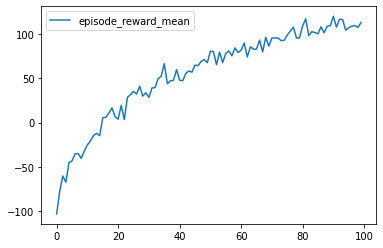

In [16]:
data.plot(y='episode_reward_mean', kind='line')